In [2]:
pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 71.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38247 sha256=f83d9eba6ae9c3db802ffc9fad4248c9ec085f2dfe714b5696dcfd9accb597bb
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam


In [9]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, XGradCAM, EigenCAM, GradCAMElementWise
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import torch
import time
from tabulate import tabulate

import warnings
warnings.filterwarnings("ignore")

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Load pre-trained ResNet model
model = resnet50(pretrained=True).to(device)
model.eval()

# Choose the target layer for visualization
target_layers = [model.layer4[-1]]

gradCAM = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
gradCAMPP = GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=True)
eigCAM = EigenCAM(model=model, target_layers=target_layers, use_cuda=True)
scoreCAM = ScoreCAM(model=model, target_layers=target_layers, use_cuda=True)
gradCAMew = GradCAMElementWise(model=model, target_layers=target_layers, use_cuda=True)
xGradCAM = XGradCAM(model=model, target_layers=target_layers, use_cuda=True)

cams = [gradCAM, gradCAMPP, eigCAM, scoreCAM, gradCAMew, xGradCAM]
cams_names = ['Grad-CAM', 'Grad-CAM++', 'Eigen-CAM', 'Score-CAM', 'Grad-CAM ElementWise', 'XGrad-CAM']

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 185MB/s]


In [5]:
def gradCAM_heatMaps_times(image_path):

  visualizations = []
  times = []
  # Load the image
  image = Image.open(image_path)

  # Apply transformations
  transformed_image = transform(image).unsqueeze(0).to(device)

  rgb_img = transformed_image.detach().cpu().numpy().reshape(3,224,224)
  rgb_img = np.transpose(rgb_img, (1,2,0)) / 255

  # Forward pass through the model
  output = model(transformed_image)
  _,predClass = torch.max(output, 1)

  # Get the predicted class index
  targets = [ClassifierOutputTarget(predClass)]

  for cam in cams:
    # record the time
    start_time = time.time()
    # Calculate the Grad-CAM attribution map
    attribution_map = cam(input_tensor=transformed_image, targets=targets)
    end_time = time.time()

    attribution_map = attribution_map[0, :]
    visualization = show_cam_on_image(rgb_img, attribution_map, use_rgb=True)
    visualizations.append(visualization)
    times.append(end_time - start_time)

  return rgb_img, visualizations, times

In [6]:
def my_plot(image_path):

  rgb_img, visualizations, times = gradCAM_heatMaps_times(image_path)

  #Display the original image and the superimposed image
  plt.figure(figsize=(8, 5))
  plt.imshow(rgb_img * 255)
  plt.title('Original Image')


  fig, axes = plt.subplots(1, 6, figsize=(25, 10))
  for idx in range(len(cams)):
    axes[idx].imshow(visualizations[idx])
    axes[idx].axis('off')
    axes[idx].set_title(cams_names[idx] + ' Visualization')

  plt.show()


  # Zip the lists together into pairs
  data = list(zip(cams_names, times))
  sorted_data = sorted(data, key=lambda x: x[1])

  # Create the table with headers and sorted data and print the sorted table
  table = tabulate(sorted_data, headers=["CAM-Name", "Time (s)"])
  print(table)

  print('\n\n\n')

100%|██████████| 128/128 [00:06<00:00, 19.17it/s]


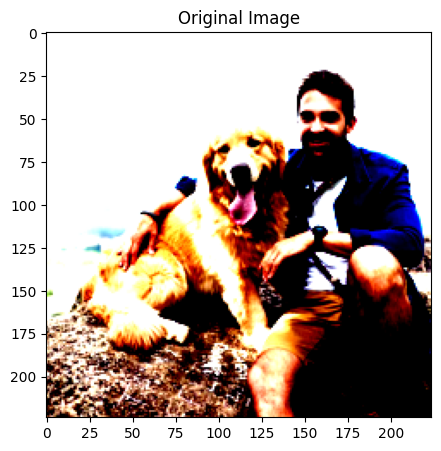

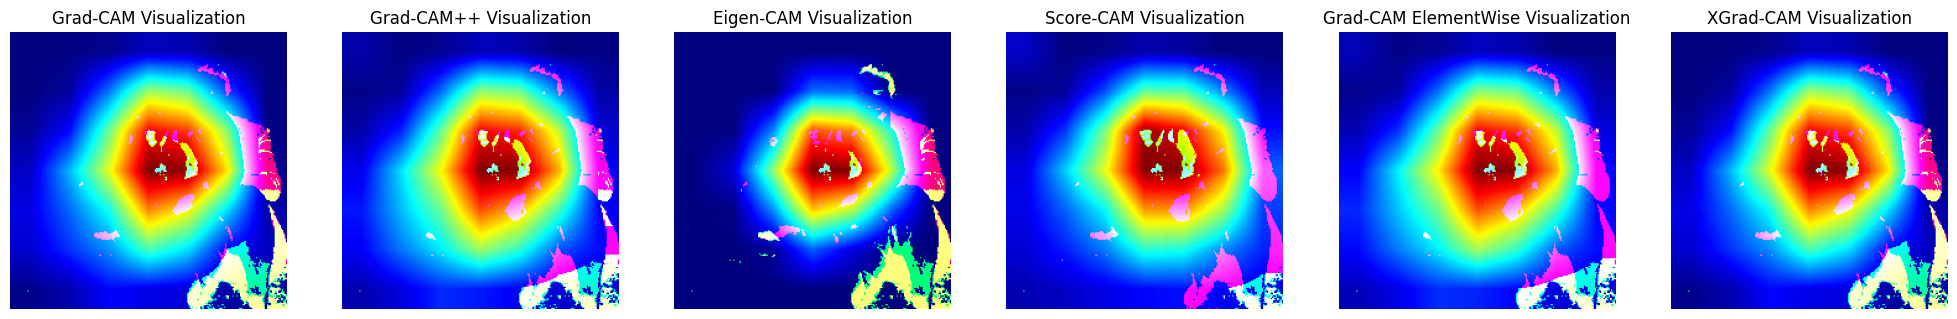

CAM-Name                Time (s)
--------------------  ----------
Grad-CAM ElementWise   0.0198259
XGrad-CAM              0.0201173
Grad-CAM               0.0228107
Grad-CAM++             0.0276353
Eigen-CAM              0.331385
Score-CAM              6.70116






100%|██████████| 128/128 [00:06<00:00, 18.90it/s]


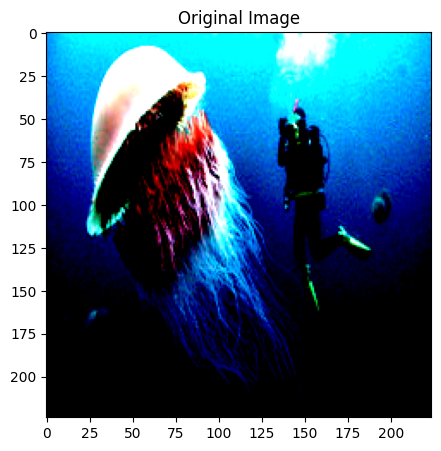

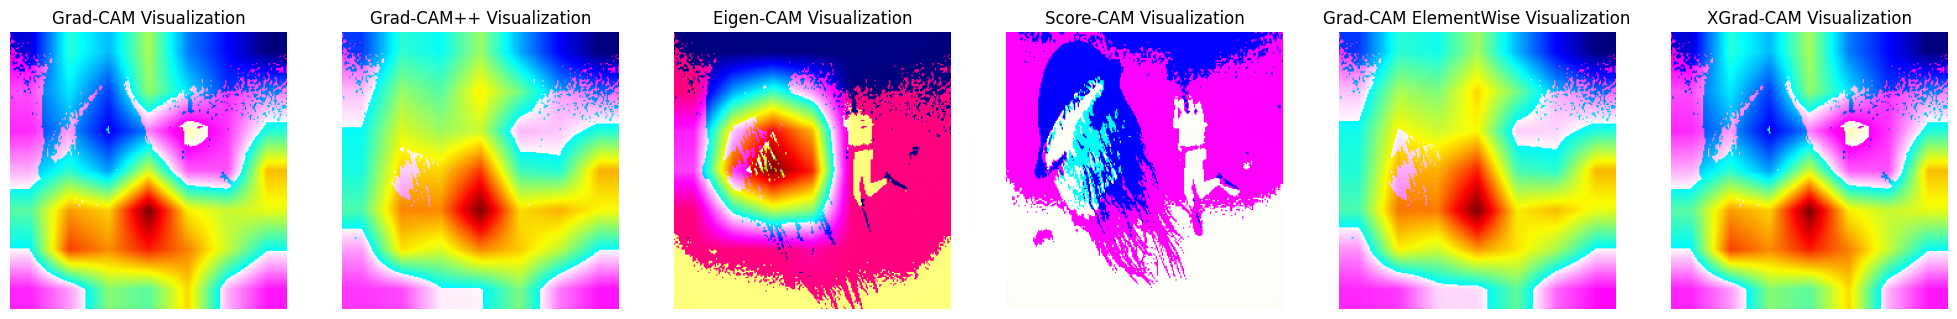

CAM-Name                Time (s)
--------------------  ----------
Grad-CAM ElementWise   0.0210433
XGrad-CAM              0.0213616
Grad-CAM               0.023474
Grad-CAM++             0.0307457
Eigen-CAM              0.31749
Score-CAM              6.79883






In [10]:
image_paths = ['/content/Golden Retreiver.jpg', '/content/JellyFish and Diver.jpg']


for image_path in image_paths:
  my_plot(image_path)

## Metrics

In [16]:
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget
from pytorch_grad_cam.metrics.cam_mult_image import CamMultImageConfidenceChange
from pytorch_grad_cam.metrics.road import ROADMostRelevantFirst, ROADLeastRelevantFirst

In [23]:
def gradCAM_metric_scores(image_path):

  Scores = []
  # Load the image
  image = Image.open(image_path)

  # Apply transformations
  transformed_image = transform(image).unsqueeze(0).to(device)

  rgb_img = transformed_image.detach().cpu().numpy().reshape(3,224,224)
  rgb_img = np.transpose(rgb_img, (1,2,0)) / 255

  # Forward pass through the model
  output = model(transformed_image)
  _,predClass = torch.max(output, 1)

  # Get the predicted class index
  targets = [ClassifierOutputTarget(predClass)]
  cam_metric = ROADMostRelevantFirst(percentile=75)

  for cam in cams:

    # Calculate the Grad-CAM attribution map
    attribution_map = cam(input_tensor=transformed_image, targets=targets)
    #attribution_map = attribution_map[0, :]

    scores, perturbation_visualizations = cam_metric(transformed_image, attribution_map,
                                                     targets, model, return_visualization=True)

    Scores.append(scores)

  return Scores

In [24]:
Scores = gradCAM_metric_scores(image_paths[0])

100%|██████████| 128/128 [00:07<00:00, 18.19it/s]


In [26]:
print('Remove and Debias Metric')
data = list(zip(cams_names, Scores))
sorted_data = sorted(data, key=lambda x: x[1])

# Create the table with headers and sorted data and print the sorted table
table = tabulate(sorted_data, headers=["CAM-Name", "Scores"])
print(table)

CAM-Name                Scores
--------------------  --------
XGrad-CAM             -7.52687
Grad-CAM              -7.45227
Score-CAM             -6.76386
Grad-CAM ElementWise  -6.64863
Grad-CAM++            -6.64836
Eigen-CAM             -6.36036


In [31]:
# You can also average accross different percentiles, and combine
# (LeastRelevantFirst - MostRelevantFirst) / 2
from pytorch_grad_cam.metrics.road import ROADMostRelevantFirstAverage, ROADLeastRelevantFirstAverage, ROADCombined

def gradCAM_metric_scores_combined(image_path):

  Scores = []
  # Load the image
  image = Image.open(image_path)

  # Apply transformations
  transformed_image = transform(image).unsqueeze(0).to(device)

  rgb_img = transformed_image.detach().cpu().numpy().reshape(3,224,224)
  rgb_img = np.transpose(rgb_img, (1,2,0)) / 255

  # Forward pass through the model
  output = model(transformed_image)
  _,predClass = torch.max(output, 1)

  # Get the predicted class index
  targets = [ClassifierOutputTarget(predClass)]
  cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])

  for cam in cams:

    # Calculate the Grad-CAM attribution map
    attribution_map = cam(input_tensor=transformed_image, targets=targets)
    #attribution_map = attribution_map[0, :]

    scores = cam_metric(transformed_image, attribution_map,
                                                     targets, model)

    Scores.append(scores)

  return Scores

In [32]:
Scores = gradCAM_metric_scores_combined(image_paths[0])

print('Remove and Debias Combined Metric')
data = list(zip(cams_names, Scores))
sorted_data = sorted(data, key=lambda x: x[1])

# Create the table with headers and sorted data and print the sorted table
table = tabulate(sorted_data, headers=["CAM-Name", "Scores"])
print(table)

100%|██████████| 128/128 [00:07<00:00, 17.33it/s]


Remove and Debias Combined Metric
CAM-Name                Scores
--------------------  --------
Score-CAM              4.70118
Grad-CAM ElementWise   4.78862
Eigen-CAM              4.87166
Grad-CAM++             4.93161
Grad-CAM               5.04184
XGrad-CAM              5.0531
